In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
!rm -rf cifar-10-batches-py

In [ ]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O - | tar -xz

--2021-05-05 11:18:46--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 162.60M  32.0MB/s    in 5.7s    

2021-05-05 11:18:52 (28.7 MB/s) - written to stdout [170498071/170498071]



### read dataset

In [ ]:
train = []
label = []
nums = [chr(ord('1')+i) for i in range(5)]
for i in nums:
  train.append(unpickle('/content/cifar-10-batches-py/data_batch_'+i)[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8"))
  label.append(unpickle('/content/cifar-10-batches-py/data_batch_'+i)[b'labels'])

train = np.vstack(train)
label = np.hstack(label)

In [ ]:
test = unpickle('/content/cifar-10-batches-py/test_batch')[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_label = np.array(unpickle('/content/cifar-10-batches-py/test_batch')[b'labels'])

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### visualize sample

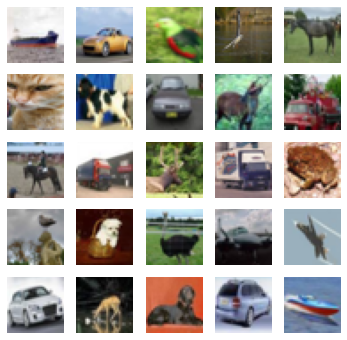

In [ ]:
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(6,6))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(train[i:i+1][0])

### Noramlization and convert labels to one-hot vectors

In [ ]:
# Change to float datatype
train = train.astype('float32')
test = test.astype('float32')

# Noramlization from [0;255] to [0;1], Scale the data to lie between 0 to 1
train /= 255
test /= 255

# convert labels to one-hot vectors
from keras.utils import np_utils
label = np_utils.to_categorical(label)
test_label = np_utils.to_categorical(test_label)

### classification

In [ ]:
from keras.models import Sequential
from keras.utils import np_utils
from keras import layers

def create(nl=1, act='relu', opt='Adam', dcnv=True, drp=False, filter=[32,64,128], kernel=[3,3,3], eln=[128,64], drp_v = [0.3, 0.5]):
  model = Sequential()

  if dcnv:
    model.add(layers.Conv2D(filters=filter[0], kernel_size=kernel[0], padding='same', activation=act, input_shape=(32,32,3))) 
    model.add(layers.Conv2D(filters=filter[0], kernel_size=kernel[0], padding='same', activation=act))
  else:
    model.add(layers.Conv2D(filters=filter[0], kernel_size=(kernel[0]*2)-1, padding='same', activation=act, input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=2))
  if drp:
    model.add(layers.Dropout(drp_v[0]))

  if dcnv:
    model.add(layers.Conv2D(filters=filter[1], kernel_size=kernel[1], padding='same', activation=act))
    model.add(layers.Conv2D(filters=filter[1], kernel_size=kernel[1], padding='same', activation=act))
  else:
    model.add(layers.Conv2D(filters=filter[1], kernel_size=(kernel[1]*2)-1, padding='same', activation=act))
  model.add(layers.MaxPooling2D(pool_size=2))
  if drp:
    model.add(layers.Dropout(drp_v[0]))

  if dcnv:
    model.add(layers.Conv2D(filters=filter[2], kernel_size=kernel[2], padding='same', activation=act))
    model.add(layers.Conv2D(filters=filter[2], kernel_size=kernel[2], padding='same', activation=act))
  else:
    model.add(layers.Conv2D(filters=filter[2], kernel_size=(kernel[2]*2)-1, padding='same', activation=act))
  model.add(layers.MaxPooling2D(pool_size=2))
  if drp:
    model.add(layers.Dropout(drp_v[0]))

  model.add(layers.Flatten())
  for i in range(nl):
    model.add(layers.Dense(eln[i], activation=act))
    if drp:
      model.add(layers.Dropout(drp_v[1]))
  model.add(layers.Dense(10, activation='softmax'))

  model.summary()

  # Configure the Network
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#### base model
- activation: relu
- optimizer: adam
- num of hidden number: 1

In [ ]:
model = create()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [ ]:
def plot_metrics(history, title):
  # Plotting Metrics
  # Plot the Accuracy Curves
  fig = plt.figure()
  plt.plot(history.history['accuracy'],'r')
  plt.plot(history.history['val_accuracy'],'b')
  plt.title('model accuracy '+str(title))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.grid()

  print()
  print('train:', max(history.history['accuracy']), np.argmax(history.history['accuracy']))
  print('test:', max(history.history['val_accuracy']), np.argmax(history.history['val_accuracy']))

Epoch 1/25
782/782 [==============================] - 19s 21ms/step - loss: 1.7586 - accuracy: 0.3480 - val_loss: 1.2706 - val_accuracy: 0.5552

Epoch 00001: val_loss improved from inf to 1.27062, saving model to model_best_weights.h5
Epoch 2/25
782/782 [==============================] - 15s 20ms/step - loss: 1.0544 - accuracy: 0.6273 - val_loss: 0.9691 - val_accuracy: 0.6596

Epoch 00002: val_loss improved from 1.27062 to 0.96914, saving model to model_best_weights.h5
Epoch 3/25
782/782 [==============================] - 16s 20ms/step - loss: 0.8047 - accuracy: 0.7170 - val_loss: 0.7690 - val_accuracy: 0.7304

Epoch 00003: val_loss improved from 0.96914 to 0.76902, saving model to model_best_weights.h5
Epoch 4/25
782/782 [==============================] - 16s 20ms/step - loss: 0.6382 - accuracy: 0.7763 - val_loss: 0.7071 - val_accuracy: 0.7596

Epoch 00004: val_loss improved from 0.76902 to 0.70713, saving model to model_best_weights.h5
Epoch 5/25
782/782 [============================

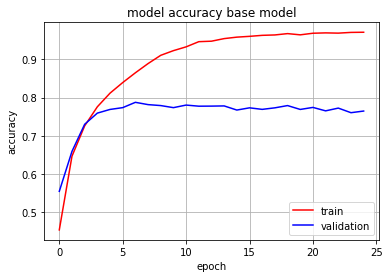

In [ ]:
from keras.callbacks import ModelCheckpoint

def fit_model(model, X_train, y_train, X_val, y_val, name, v, bsize=32, title='', eps=25):
  checkpoint = ModelCheckpoint(name, monitor='val_loss', verbose=v,
                              save_best_only=True, mode='min')
  history = model.fit(X_train, y_train, epochs=eps, batch_size=bsize, validation_data=(X_val, y_val),
                      verbose=v, callbacks=[checkpoint])
  plot_metrics(history, title)
  return model, history

model, hist = fit_model(model, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='base model')

### num of hidden layers

#### 0

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)        

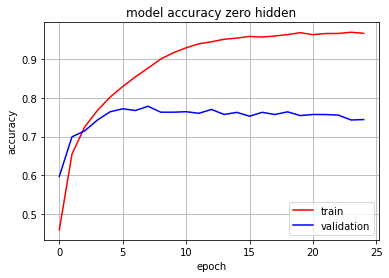

In [ ]:
model_0 = create(nl=0)
model_0, hist_0 = fit_model(model_0, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='zero hidden')

### 2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

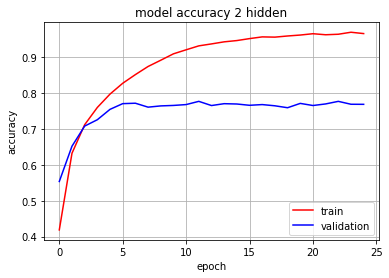

In [ ]:
model_2 = create(nl=2)
model_2, hist_2 = fit_model(model_2, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='2 hidden')

### activation function

#### tanh

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)        

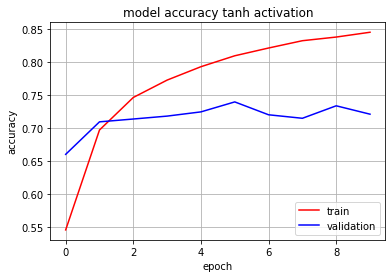

In [ ]:
model_tan = create(nl=1, act='tanh')
model_tan, hist_tan = fit_model(model_tan, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='tanh activation', eps=10)

#### sigmoid

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)        

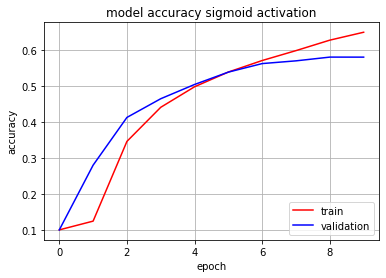

In [ ]:
model_sigm = create(nl=1, act='sigmoid')
model_sigm, hist_sigm = fit_model(model_sigm, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='sigmoid activation', eps=10)

#### compare activations

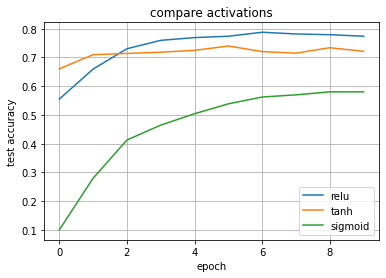

In [ ]:
plt.plot(hist.history['val_accuracy'][:10], label='relu')
plt.plot(hist_tan.history['val_accuracy'][:10], label='tanh')
plt.plot(hist_sigm.history['val_accuracy'][:10], label='sigmoid')
plt.title('compare activations')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

### optimizer

#### gradient descent

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 128)        

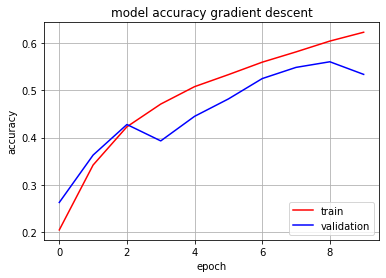

In [ ]:
model_sgd = create(nl=1, act='relu', opt='SGD')
model_sgd, hist_sgd = fit_model(model_sgd, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='gradient descent', eps=10)

#### compare optimizer

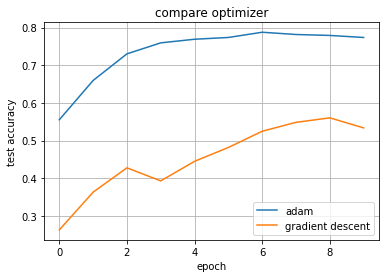

In [ ]:
plt.plot(hist.history['val_accuracy'][:10], label='adam')
plt.plot(hist_sgd.history['val_accuracy'][:10], label='gradient descent')
plt.title('compare optimizer')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

### reduce data, 600 in all class

#### reduce train data

In [ ]:
new_train = []
new_label = []
indxs = [[] for i in range(len(classes))]
for i, v in enumerate(label):
  indxs[np.argmax(v)].append(i)

for i in indxs:
  new_train.append(train[i[:600]])
  new_label.append(label[i[:600]])

new_label = np.array(new_label).reshape(6000,-1)
new_train = np.array(new_train).reshape(6000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

from sklearn.utils import shuffle
new_train, new_label = shuffle(new_train, new_label, random_state=0)

#### train

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 128)        

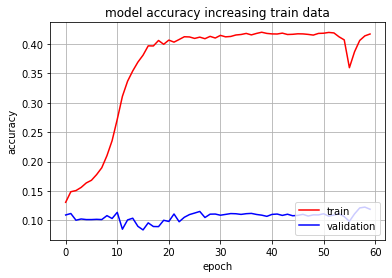

In [ ]:
model_red = create()
model_red, hist_red = fit_model(model_red, new_train, new_label, test, test_label,
                                "model_best_weights.h5", 1, bsize=64, title='increasing train data', eps=60)

#### compare with base

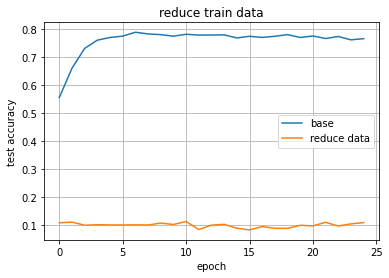

In [ ]:
plt.plot(hist.history['val_accuracy'], label='base')
plt.plot(hist_red.history['val_accuracy'][:25], label='reduce data')
plt.title('reduce train data')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

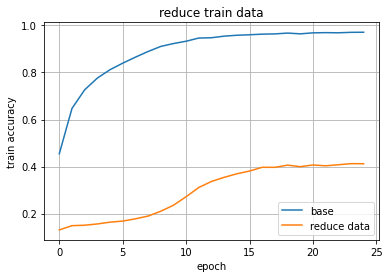

In [ ]:
plt.plot(hist.history['accuracy'], label='base')
plt.plot(hist_red.history['accuracy'][:25], label='reduce data')
plt.title('reduce train data')
plt.ylabel('train accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

### convert two conv to one conve, increase kernel size

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)             

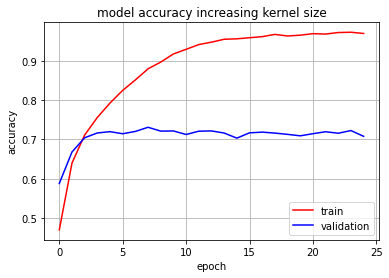

In [ ]:
model_cnv = create(nl=1, act='relu', opt='Adam', dcnv=False)
model_cnv, hist_cnv = fit_model(model_cnv, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='increasing kernel size')

#### 2-conv vs 1-conv with increasing kernel size 

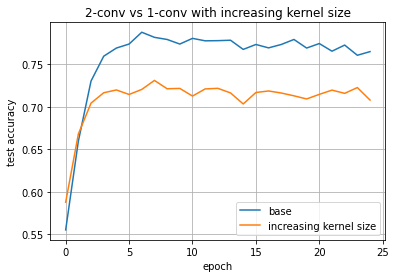

In [ ]:
plt.plot(hist.history['val_accuracy'], label='base')
plt.plot(hist_cnv.history['val_accuracy'], label='increasing kernel size')
plt.title('2-conv vs 1-conv with increasing kernel size')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

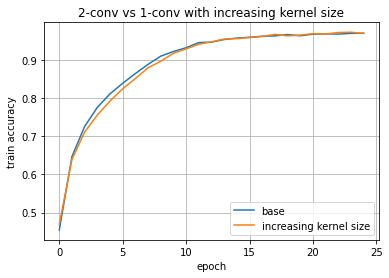

In [ ]:
plt.plot(hist.history['accuracy'], label='base')
plt.plot(hist_cnv.history['accuracy'], label='increasing kernel size')
plt.title('2-conv vs 1-conv with increasing kernel size')
plt.ylabel('train accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

### dropout

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 8, 8, 64)        

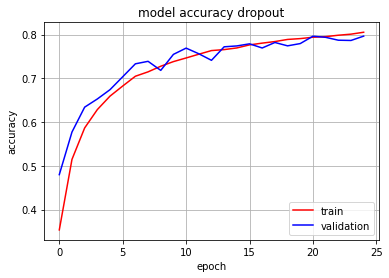

In [ ]:
model_drp = create(nl=1, act='relu', opt='Adam', dcnv=True, drp=True, filter=[32,64,128], kernel=[3,3,3], eln=[128,64], drp_v = [0.3, 0.3])
model_drp, hist_drp = fit_model(model_drp, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='dropout')

#### effect of drop out

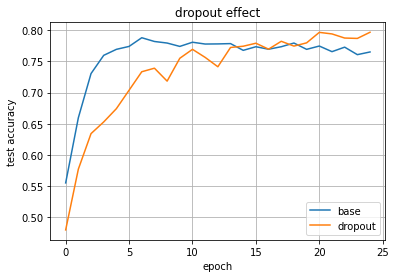

In [ ]:
plt.plot(hist.history['val_accuracy'], label='base')
plt.plot(hist_drp.history['val_accuracy'], label='dropout')
plt.title('dropout effect')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

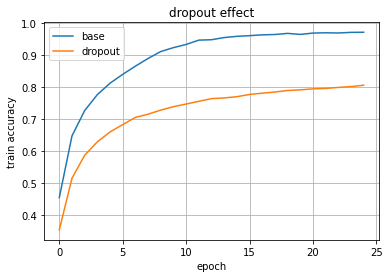

In [ ]:
plt.plot(hist.history['accuracy'], label='base')
plt.plot(hist_drp.history['accuracy'], label='dropout')
plt.title('dropout effect')
plt.ylabel('train accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

#### find best drop probability

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 64)        

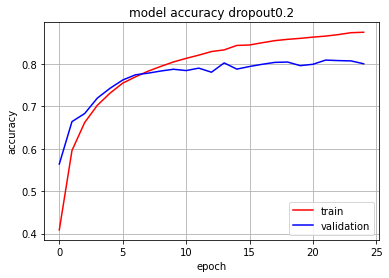

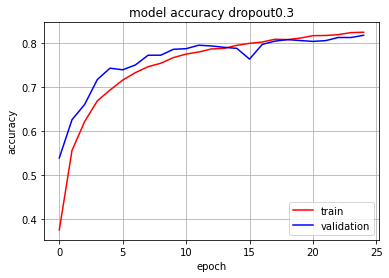

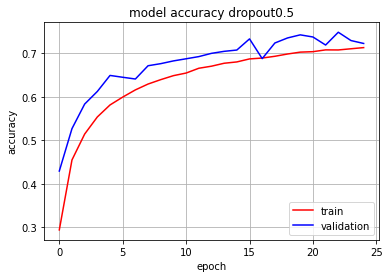

In [ ]:
prs = [0.2, 0.3, 0.5]

for i in prs:
  model_drp = create(nl=1, act='relu', opt='Adam', dcnv=True, drp=True, filter=[32,64,128], kernel=[3,3,3], eln=[128,64], drp_v = [i, i])
  model_drp, hist_drp = fit_model(model_drp, train, label, test, test_label, "model_best_weights.h5", 1, bsize=64, title='dropout'+str(i))